In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from timeit import default_timer as timer
import numpy as np
import const
import os
import random
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
#Définition des chemins
diverted_images_train_path = os.path.join(const.DATASET_TEST, "train")
diverted_images_valid_path = os.path.join(const.DATASET_TEST, "valid")
diverted_images_test_path = os.path.join(const.DATASET_TEST, "test")

# Définition de la taille du lot
batch_size = 16

# Définition des callbacks
reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", patience=2, min_delta=0.01, factor=0.1, cooldown=4, verbose=1)
early_stopping = EarlyStopping(patience=3, min_delta=0.01, verbose=1, mode='min', monitor='val_loss')

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

# Création des générateurs d'images avec augmentation des données
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(diverted_images_train_path, target_size=(224, 224), batch_size=batch_size)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    diverted_images_test_path, 
    target_size=(224, 224), 
    batch_size=batch_size
)

valid_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

valid_generator = valid_datagen.flow_from_directory(diverted_images_valid_path, target_size=(224, 224), batch_size=batch_size)

# Construction du modèle
def build_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False)
    for layer in base_model.layers[:-20]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1280, activation='relu')(x) 
    x = Dropout(rate=0.3)(x)
    x = Dense(640, activation='relu')(x)  
    x = Dropout(rate=0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

num_classes = len(train_generator.class_indices)
model = build_model(num_classes)

# Compilation du modèle
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc', 'mean_absolute_error'])

# Entraînement du modèle
history_diverted = model.fit(train_generator,
                    epochs=2,  
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//valid_generator.batch_size,
                    callbacks=[reduce_learning_rate, early_stopping, time_callback], verbose=1)

# Évaluation du modèle
test_accuracy = model.evaluate(test_generator)
print(test_accuracy)
print(history_diverted.history['val_acc'][-1])

Found 3606 images belonging to 23 classes.
Found 3448 images belonging to 23 classes.
Found 115 images belonging to 23 classes.
Epoch 1/2
225/225 [==============================] - 111s 466ms/step - loss: 0.5052 - acc: 0.8524 - mean_absolute_error: 0.0171 - val_loss: 0.1578 - val_acc: 0.9554 - val_mean_absolute_error: 0.0045 - lr: 0.0010
Epoch 2/2
216/216 [==============================] - 48s 222ms/step - loss: 0.0714 - acc: 0.9800 - mean_absolute_error: 0.0021
[0.07142041623592377, 0.9799883961677551, 0.0021426728926599026]
0.9732142686843872
Saved model to disk


In [4]:
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

   
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

 
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

   
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
  
    img = image.load_img(img_path)
    img = image.img_to_array(img)

   
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

   
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

  
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    plt.imshow(superimposed_img)
    plt.show()

..\data\data_test\test


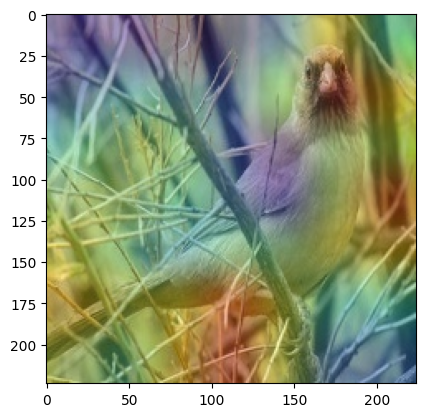

In [5]:
folder_path = random.choice([diverted_images_train_path, diverted_images_valid_path, diverted_images_test_path])
images = [os.path.join(dp, f) for 
          dp, dn, filenames in os.walk(folder_path) 
          for f in filenames if os.path.splitext(f)[1] == '.jpg']
img_path = random.choice(images)


last_conv_layer_name = 'top_conv'  
img_array = preprocess_input(get_img_array(img_path, size=(224, 224)))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
save_and_display_gradcam(img_path,heatmap)